## Сущевский

1) Файл HW1.txt
2) Обработать файл с помощью регулярных выражений, убрать лишние символы, оставить только абстракты
3) Провести предобработку текста
4) Провести тематическое моделирование с помощью LSI и LDA моделей
5) Оптимизировать количество топиков (Coherence Metrics)
6) Визулизировать темы гистограммой (статическая визуализация)
7) Сравнить полученные результаты

Дедлайн 21.10.21

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
nlp = spacy.load('en_core_web_sm')
# from spacy.lemmatizer import Lemmatizer
# from spacy.lang.en.stop_words import STOP_WORDS
# import en_core_web_lg

from tqdm.notebook import tqdm
from pprint import pprint

In [ ]:
# # nlp.add_pipe("lemmatizer")
# from spacy.language import Language
# @Language.component("remove_stopwords")
# def remove_stopwords(doc):
#     # This will remove stopwords and punctuation.
#     # Use token.text to return strings, which we'll need for Gensim.
#     doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
#     return doc
# nlp.add_pipe('remove_stopwords', name="stopwords", last=True)

In [3]:
# import nltk
# from nltk.tokenize import RegexpTokenizer
# from nltk.stem import WordNetLemmatizer,PorterStemmer
# # nltk.download('stopwords')
# # nltk.download('wordnet')
# from nltk.corpus import stopwords
# import re
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()
#
# def preprocess(sentence):
#     sentence=str(sentence)
#     sentence = sentence.lower()
#     sentence=sentence.replace('{html}',"")
#     sentence=sentence.replace('-------------------', '')
#     cleanr = re.compile('<.*?>')
#     cleantext = re.sub(cleanr, '', sentence)
#     rem_url=re.sub(r'http\S+', '',cleantext)
#     rem_num = re.sub('[0-9]+', '', rem_url)
#     tokenizer = RegexpTokenizer(r'\w+')
#     tokens = tokenizer.tokenize(rem_num)
#     filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
#     stem_words=[stemmer.stem(w) for w in filtered_words]
#     lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
#     return " ".join(lemma_words)

## Файл HW1.txt
### Обработать файл с помощью регулярных выражений, убрать лишние символы, оставить только абстракты

берём все строчки которые начинаются со слова Abstract, пока не встретится новое поле

In [4]:
with open('HW1.txt') as f:
    texts = f.readlines()
abst = 0
abstracts = []
for text in texts:
    text = text.strip()
    if abst == 0:
        if text.startswith('Abstract'):
            abst = 1
            abstracts.append(text)
            pass
    elif abst == 1:
        if text.startswith('Key'):
            abst = 0
        else:
            abstracts[-1] = abstracts[-1] + " " +  text + " "
abstracts

['Abstract: Applying a series of techniques intended to induce, detect and isolate lethal and/or sterile temperature-sensitive  mutants, specific to the self-fertilizing hermaphrodite  nematode Caenorhabditis elegans, Bergerac strain, 25 such  mutants have been found.  Optimal conditions for the  application of mutagenic treatment and the detection of  such mutations are discussed.  ------------------- ',
 'Abstract: Before diakinesis, the development of the oocytes of C. elegans takes place in the presence of a specific  anatomical structure: the rachis.  This is an undivided,  anucleated cytoplasmic mass placed in the central part of  the ovary.  Electron microscopy shows that, at first, in  the gonial region, it is made of two branches which  infiltrate themselves between the oogonia and then converge  in a single axial column.  Afterwards, this column will be  pushed to the outside of the gonad and will disappear when  the great oocyte increase takes place.  Until then, the  rachis

## Провести предобработку текста
оставим лемматизированные слова и только слова
уберём стоп слова

In [19]:
docs = list(nlp.pipe(abstracts))
docs

[Abstract: Applying a series of techniques intended to induce, detect and isolate lethal and/or sterile temperature-sensitive  mutants, specific to the self-fertilizing hermaphrodite  nematode Caenorhabditis elegans, Bergerac strain, 25 such  mutants have been found.  Optimal conditions for the  application of mutagenic treatment and the detection of  such mutations are discussed.  ------------------- ,
 Abstract: Before diakinesis, the development of the oocytes of C. elegans takes place in the presence of a specific  anatomical structure: the rachis.  This is an undivided,  anucleated cytoplasmic mass placed in the central part of  the ovary.  Electron microscopy shows that, at first, in  the gonial region, it is made of two branches which  infiltrate themselves between the oogonia and then converge  in a single axial column.  Afterwards, this column will be  pushed to the outside of the gonad and will disappear when  the great oocyte increase takes place.  Until then, the  rachis is

In [43]:
docs_clean = []
for doc in docs:
    small_list = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and token.is_alpha:
            small_list.append(token.lemma_)
    docs_clean.append(small_list)
docs_clean

[['abstract',
  'apply',
  'series',
  'technique',
  'intend',
  'induce',
  'detect',
  'isolate',
  'lethal',
  'sterile',
  'temperature',
  'sensitive',
  'mutant',
  'specific',
  'self',
  'fertilize',
  'hermaphrodite',
  'nematode',
  'Caenorhabditis',
  'elegan',
  'Bergerac',
  'strain',
  'mutant',
  'find',
  'optimal',
  'condition',
  'application',
  'mutagenic',
  'treatment',
  'detection',
  'mutation',
  'discuss'],
 ['abstract',
  'diakinesis',
  'development',
  'oocyte',
  'elegans',
  'take',
  'place',
  'presence',
  'specific',
  'anatomical',
  'structure',
  'rachis',
  'undivided',
  'anucleate',
  'cytoplasmic',
  'mass',
  'place',
  'central',
  'ovary',
  'Electron',
  'microscopy',
  'show',
  'gonial',
  'region',
  'branch',
  'infiltrate',
  'oogonia',
  'converge',
  'single',
  'axial',
  'column',
  'column',
  'push',
  'outside',
  'gonad',
  'disappear',
  'great',
  'oocyte',
  'increase',
  'take',
  'place',
  'rachis',
  'limit',
  'envel

## 4) Провести тематическое моделирование с помощью LSI и LDA моделей
### LSI

In [56]:
bad_words = ["abstract", "C.", "si", 'x', "g", "cell", "gene"]
clean_text = [
    [word for word in document if word not in bad_words]
    for document in docs_clean
]
clean_text

[['apply',
  'series',
  'technique',
  'intend',
  'induce',
  'detect',
  'isolate',
  'lethal',
  'sterile',
  'temperature',
  'sensitive',
  'mutant',
  'specific',
  'self',
  'fertilize',
  'hermaphrodite',
  'nematode',
  'Caenorhabditis',
  'elegan',
  'Bergerac',
  'strain',
  'mutant',
  'find',
  'optimal',
  'condition',
  'application',
  'mutagenic',
  'treatment',
  'detection',
  'mutation',
  'discuss'],
 ['diakinesis',
  'development',
  'oocyte',
  'elegans',
  'take',
  'place',
  'presence',
  'specific',
  'anatomical',
  'structure',
  'rachis',
  'undivided',
  'anucleate',
  'cytoplasmic',
  'mass',
  'place',
  'central',
  'ovary',
  'Electron',
  'microscopy',
  'show',
  'gonial',
  'region',
  'branch',
  'infiltrate',
  'oogonia',
  'converge',
  'single',
  'axial',
  'column',
  'column',
  'push',
  'outside',
  'gonad',
  'disappear',
  'great',
  'oocyte',
  'increase',
  'take',
  'place',
  'rachis',
  'limit',
  'envelope',
  'connect',
  'germin

In [57]:
#  создаем словарь
dictionary = corpora.Dictionary(clean_text)
# проводим векторизацию
corpus = [dictionary.doc2bow(text) for text in clean_text]
# # tfidf model
tfidf_model = models.TfidfModel(corpus)
# # tfidf
tfidf = tfidf_model[corpus]

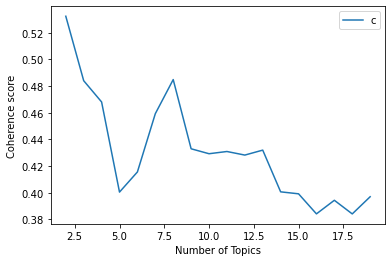

In [58]:
import matplotlib.pyplot as plt


def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = models.LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,20,1
plot_graph(clean_text,start,stop,step)

чётко видим 8 топиков, и дальше модель стала ухудшаться, остановимся на 8
брать меньше 5 топиков бессмысленно даже для LSI,

## LDA моделей

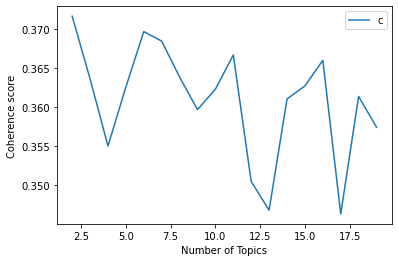

In [59]:
def compute_coherence_values_2(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = models.LdaMulticore(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph_2(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values_2(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,20,1
plot_graph_2(clean_text,start,stop,step)

Видно, что данные не очень подходят для тематического моделирования, возможно, ЛДА спотыкается о частые слова, которые обычно тоже нужно убирать, но посмотрим на результат
хотя я выкинул cell и gene
ну пусть будет 11 тем

In [64]:
lsi = models.LsiModel(tfidf, id2word=dictionary, num_topics=8)

In [65]:
lsi.print_topics(num_words=10)

[(0,
  '0.155*"protein" + 0.133*"mutation" + 0.123*"mutant" + 0.116*"sequence" + 0.109*"signal" + 0.106*"expression" + 0.105*"function" + 0.103*"development" + 0.098*"pathway" + 0.088*"genetic"'),
 (1,
  '-0.280*"sequence" + 0.219*"vulval" + 0.208*"fate" + 0.191*"signal" + 0.162*"pathway" + -0.134*"element" + -0.118*"acid" + -0.117*"genome" + -0.114*"region" + -0.113*"amino"'),
 (2,
  '0.228*"life" + 0.187*"span" + 0.181*"male" + 0.170*"chromosome" + -0.168*"receptor" + 0.166*"sex" + -0.153*"protein" + -0.149*"kinase" + -0.147*"signal" + 0.146*"hermaphrodite"'),
 (3,
  '-0.290*"death" + -0.230*"life" + 0.202*"chromosome" + -0.198*"span" + 0.172*"sex" + 0.150*"germ" + 0.148*"male" + -0.134*"age" + -0.133*"dauer" + 0.126*"hermaphrodite"'),
 (4,
  '0.600*"death" + 0.257*"program" + -0.174*"muscle" + -0.146*"mutant" + 0.141*"apoptosis" + -0.139*"dauer" + -0.120*"neuron" + -0.113*"myosin" + -0.109*"mutation" + 0.102*"sex"'),
 (5,
  '-0.798*"French" + 0.184*"death" + 0.141*"muscle" + -0.137*

In [62]:
lda_model = models.LdaMulticore(tfidf, num_topics=11, id2word=dictionary)

In [63]:
lda_model.print_topics(num_words=10)

[(0,
  '0.002*"protein" + 0.002*"mutation" + 0.002*"death" + 0.002*"signal" + 0.002*"mutant" + 0.002*"function" + 0.002*"development" + 0.002*"nematode" + 0.002*"neuron" + 0.001*"pathway"'),
 (1,
  '0.002*"French" + 0.002*"protein" + 0.002*"sequence" + 0.002*"mutation" + 0.002*"RNA" + 0.001*"mutant" + 0.001*"function" + 0.001*"chromosome" + 0.001*"acid" + 0.001*"domain"'),
 (2,
  '0.002*"protein" + 0.002*"mutation" + 0.002*"mutant" + 0.002*"sequence" + 0.001*"muscle" + 0.001*"nematode" + 0.001*"animal" + 0.001*"function" + 0.001*"domain" + 0.001*"genetic"'),
 (3,
  '0.002*"protein" + 0.002*"mutant" + 0.002*"sequence" + 0.001*"genetic" + 0.001*"nematode" + 0.001*"mutation" + 0.001*"muscle" + 0.001*"development" + 0.001*"chromosome" + 0.001*"function"'),
 (4,
  '0.002*"protein" + 0.002*"sequence" + 0.002*"fate" + 0.002*"development" + 0.002*"mutation" + 0.002*"mutant" + 0.002*"signal" + 0.002*"nematode" + 0.001*"vulval" + 0.001*"expression"'),
 (5,
  '0.002*"protein" + 0.002*"sequence" +

In [66]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, lda_model.id2word)

C:\Users\wirze\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [67]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.019348 -0.003678       1        1  18.313868
6      0.013166 -0.013417       2        1  13.239443
0      0.011727  0.000453       3        1  12.620911
5      0.010977  0.020111       4        1  11.209349
2      0.000697  0.002281       5        1  10.022107
9      0.006535 -0.007162       6        1   8.321164
8     -0.006152 -0.000219       7        1   5.646328
10    -0.006178  0.007154       8        1   5.476276
7     -0.020217  0.019678       9        1   5.333809
1     -0.021313 -0.022882      10        1   5.123377
3     -0.008589 -0.002320      11        1   4.693368, topic_info=            Term         Freq        Total Category  logprob  loglift
433       French   188.000000   188.000000  Default  30.0000  30.0000
826      protein  1109.000000  1109.000000  Default  29.0000  29.0000
127   chromosome   525.000000   525.000000  Default  28.0000  28.0000
5681      domain   553.000000   553.000000  Default  27.0000  27.0000
372     sequence   841.000000   841.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2855     pathway    25.792906   635.448398  Topic11  -6.8276  -0.1452
47       elegans    25.262755   597.736888  Topic11  -6.8483  -0.1048
5681      domain    24.782149   553.665764  Topic11  -6.8675  -0.0474
8         elegan    24.416817   531.206631  Topic11  -6.8824  -0.0209
194         type    24.539618   559.802392  Topic11  -6.8774  -0.0683

[871 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
10635      1  0.179603  ACeDB
10635      2  0.035921  ACeDB
10635      3  0.143683  ACeDB
10635      4  0.035921  ACeDB
10635      5  0.395127  ACeDB
...      ...       ...    ...
662        7  0.050392   worm
662        8  0.039894   worm
662        9  0.060891   worm
662       10  0.062990   worm
662       11  0.046193   worm

[5882 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 1, 6, 3, 10, 9, 11, 8, 2, 4])

visualization from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [69]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=clean_text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=clean_text)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             4.0              0.9716   
1            1             9.0              0.9867   
2            2             5.0              0.6279   
3            3             1.0              0.8083   
4            4             9.0              0.7494   
5            5             5.0              0.6690   
6            6             0.0              0.0909   
7            7             6.0              0.5283   
8            8             9.0              0.9292   
9            9             0.0              0.9821   

                                            Keywords  \
0  protein, sequence, fate, development, mutation...   
1  protein, mutation, mutant, function, sequence,...   
2  protein, sequence, mutant, expression, nematod...   
3  French, protein, sequence, mutation, RNA, muta...   
4  protein, mutation, mutant, function, sequence,...   
5  protein, sequence, mutant, expression, nematod...   
6  protein, mutation, death, signal, mutant, func...   
7  protein, mutant, mutation, neuron, expression,...   
8  protein, mutation, mutant, function, sequence,...   
9  protein, mutation, death, signal, mutant, func...   

                                                Text  
0  [apply, series, technique, intend, induce, det...  
1  [diakinesis, development, oocyte, elegans, tak...  
2  [Electron, microscope, study, nucleus, elegans...  
3  [oogenesis, hermaphroditic, nematode, elegans,...  
4  [postembryonic, development, nematode, Caenorh...  
5  [anatomy, pharynx, Caenorhabditis, elegan, rec...  
6                                                 []  
7  [larval, form, free, living, nematode, Caenorh...  
8  [regulator, able, maintain, stable, oxygen, co...  
9  [dispersal, behavior, Caenorhabditis, elegans,...

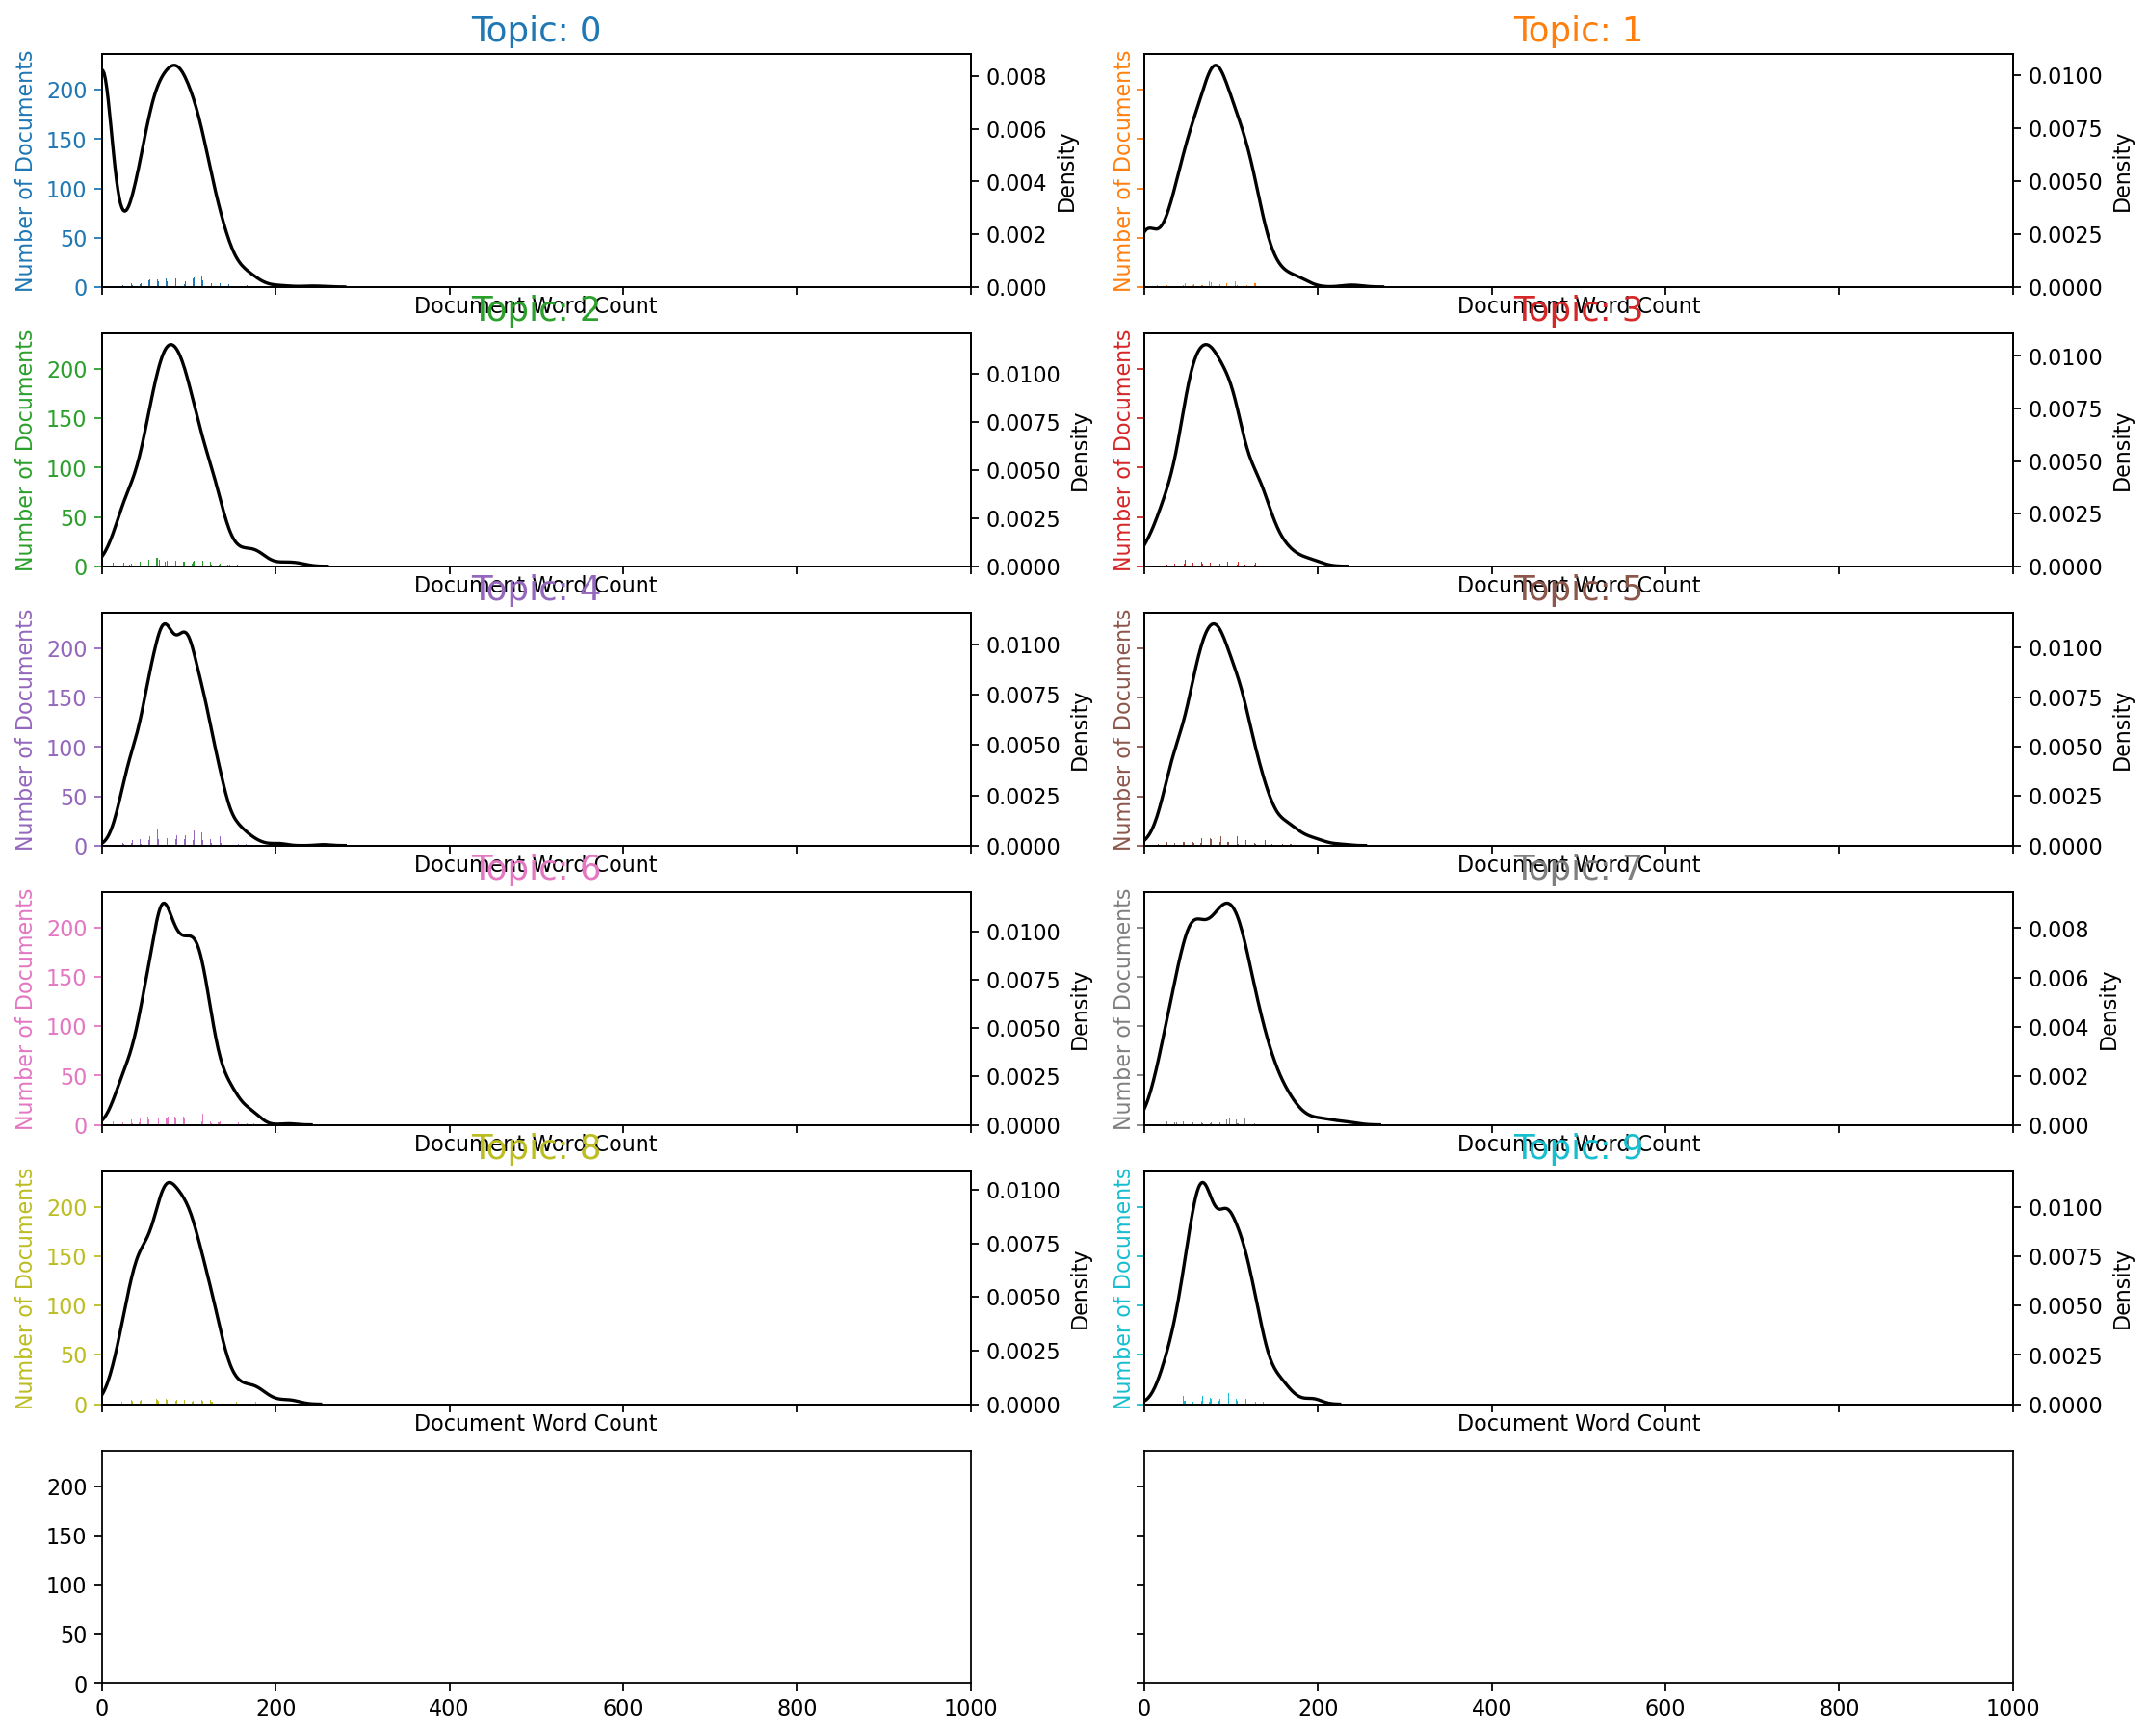

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

C:\Users\wirze\AppData\Local\Temp/ipykernel_25796/3948429888.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


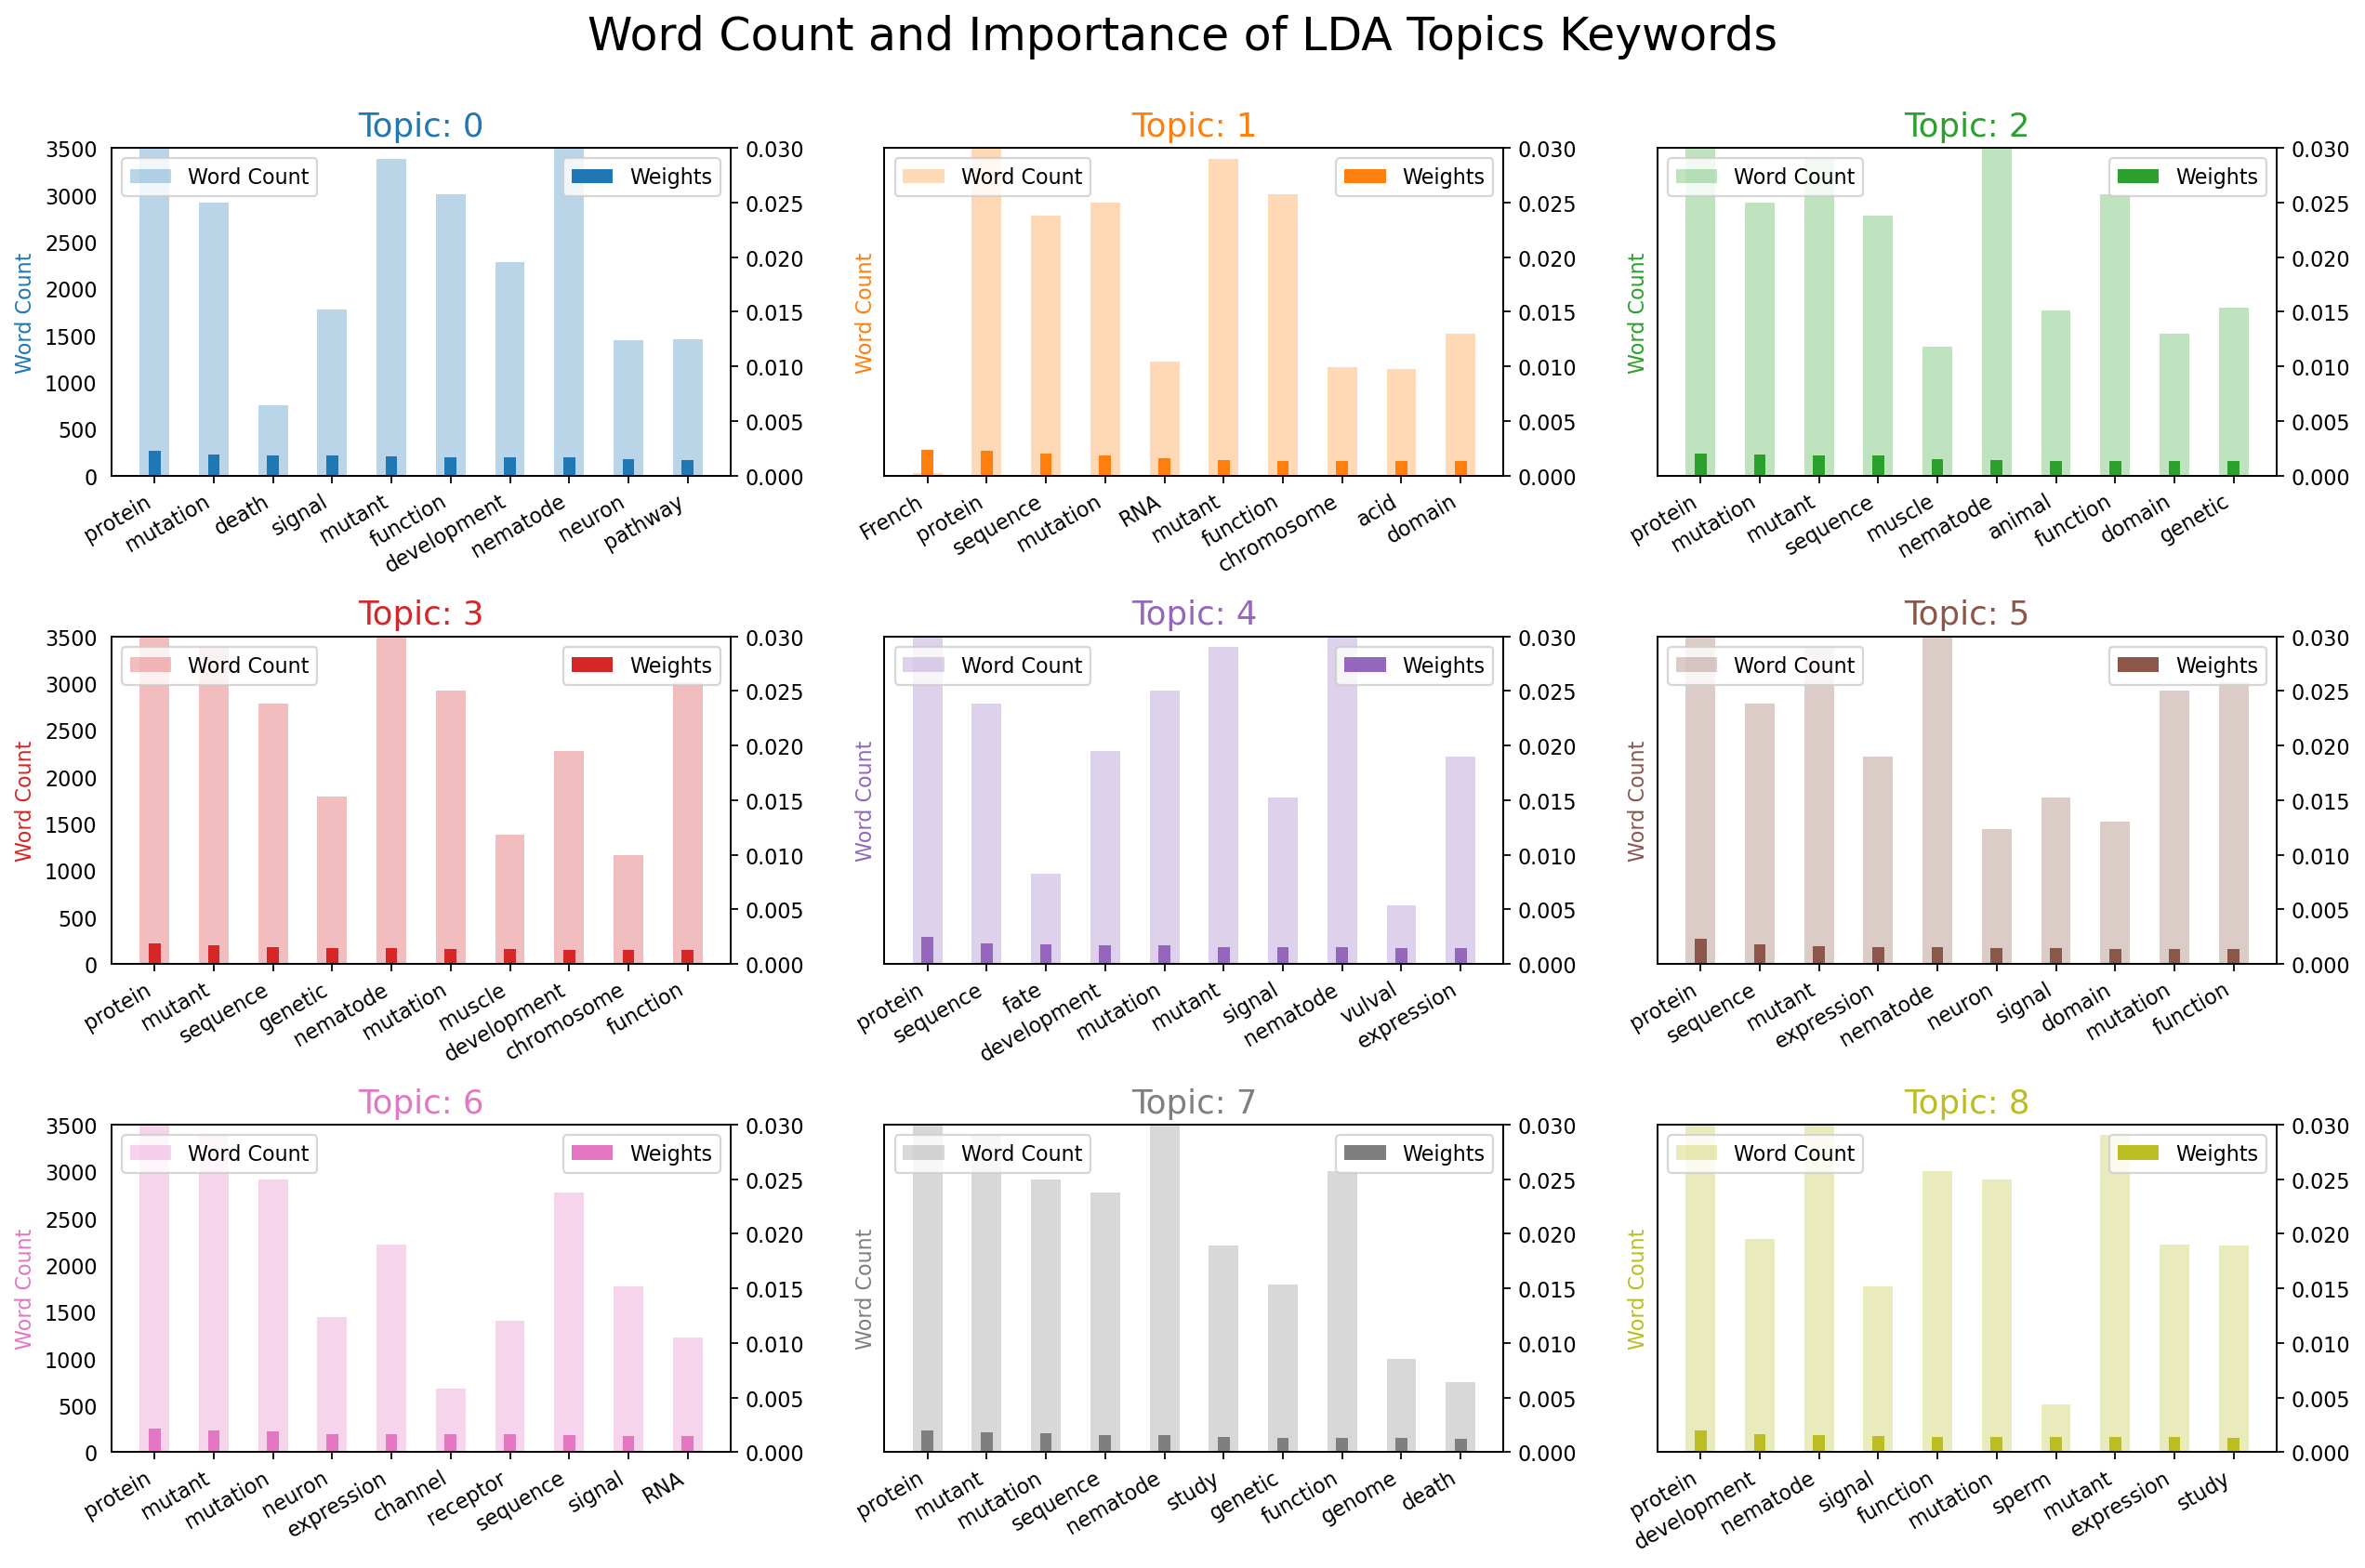

In [77]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in clean_text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of LDA Topics Keywords', fontsize=22, y=1.05)
plt.show()

In [79]:
lsi.show_topics(formatted=False)

[(0,
  [('protein', 0.15544273152431717),
   ('mutation', 0.13304312296285548),
   ('mutant', 0.12298867057421302),
   ('sequence', 0.11550412471313411),
   ('signal', 0.10941135349419877),
   ('expression', 0.10624059570899334),
   ('function', 0.10493250596491357),
   ('development', 0.10346159104608889),
   ('pathway', 0.09772407498648497),
   ('genetic', 0.08846616407469052)]),
 (1,
  [('sequence', -0.280191158761101),
   ('vulval', 0.21853102979147118),
   ('fate', 0.20827608588152838),
   ('signal', 0.19135953605998682),
   ('pathway', 0.16185051634110897),
   ('element', -0.1339816695730495),
   ('acid', -0.1183984774094028),
   ('genome', -0.11658293149314912),
   ('region', -0.11393040033876539),
   ('amino', -0.11287756585272393)]),
 (2,
  [('life', 0.22774013976478938),
   ('span', 0.18664352703843076),
   ('male', 0.1808200363572245),
   ('chromosome', 0.17028739898801745),
   ('receptor', -0.1680770448563416),
   ('sex', 0.1663592329219336),
   ('protein', -0.1528258437272

C:\Users\wirze\AppData\Local\Temp/ipykernel_25796/2862113811.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


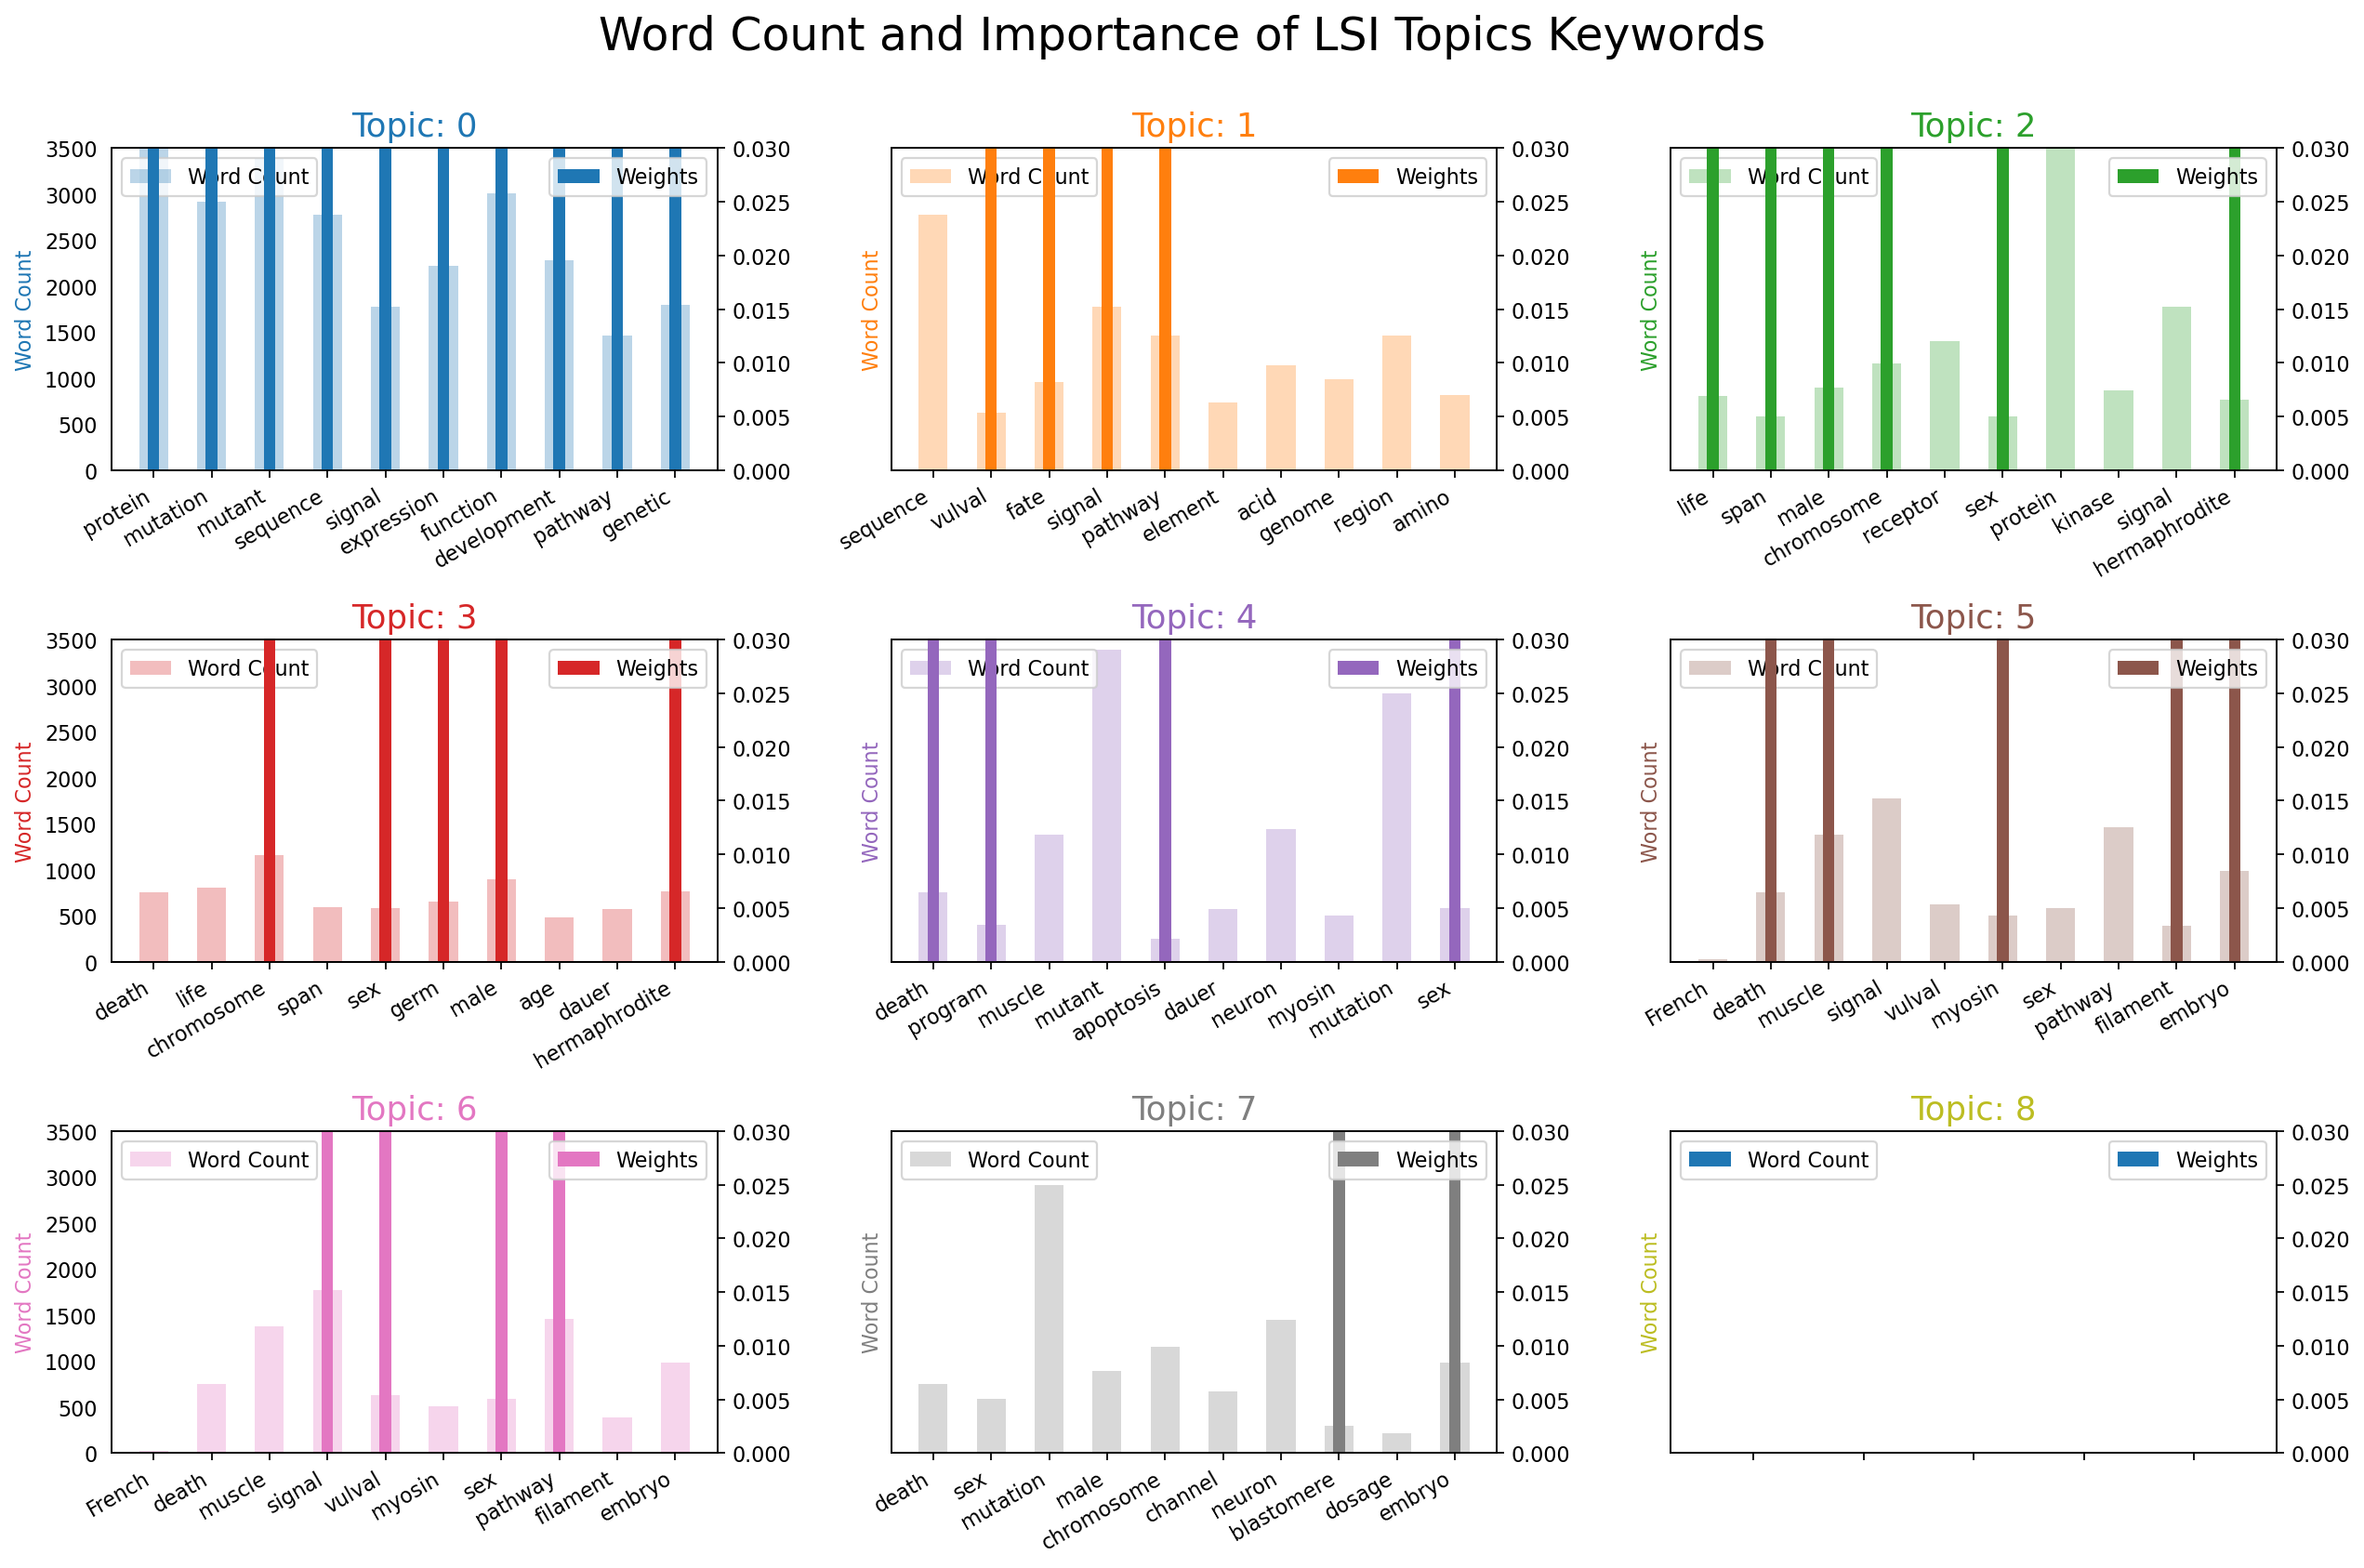

In [80]:
from collections import Counter
topics = lsi.show_topics(formatted=False)
data_flat = [w for w_list in clean_text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of LSI Topics Keywords', fontsize=22, y=1.05)
plt.show()

топики в LDA получились менее разнообразными, там везде превалирует протеин,
поэтому приходится смотреть на не самые частотные частотные слова
во втором топике выделяются french и RNA

В LSI получились более интересные результаты:
есть слова, которые в теме встречаются более часто и эксклюзивно weight больше чем word count

так во втором топике чаще встречаются продолжительность жизни и мужчины
причём реч идёт о размножении как половым путём так и при одновременном наличии признаков двух полов

в третьем топике речь чаще идёт о микробах

а в чётвёртом много объясняют что Apoptosis это запланированная смерть клетки